# Multiclass classification
## Finally!

In this notebook, we'll finally start implementing the most basic **multiclass classification** model in `PyTorch`. The good news is that everything you'll see from now in this course, it essentially a variation on the kind of matrix multiplication that is implemented in this layer.

We'll start by downloading the dataset, which is a **multiclass text classification dataset** of newswires from the Reuters agency, that have been categorized into different topical classes. We use `keras` to download this data:

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# %cd gdrive/MyDrive/my_ml_2023/session-7/

In [ ]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils



# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data()

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


This dataset comes with a standard train-test split, but they are not equal in size this time:

In [ ]:
print(len(train_data))
print(len(test_data))

8982
2246


In [ ]:
print(train_data[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


Again, the dataset comes in this funny preprocessed format. If we want to have a peak at the kind of data that is in there, we'll have to "decode" it:

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value+3, key) for (key, value) in word_index.items()])
reverse_word_index[0] = '[PAD]'
reverse_word_index[1] = '[START]'
reverse_word_index[2] = '[UNK]'
reverse_word_index[3] = '[UNS]'

decoded_newswire = ' '.join([reverse_word_index[i] for i in train_data[0]])
print(decoded_newswire)

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
[START] mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [ ]:
def decode_data(dataset):
  decoded_data = []
  for item in dataset:
    decoded_review = ' '.join([reverse_word_index[i] for i in item])
    decoded_data.append(decoded_review)
  return decoded_data


decoded_train_data = decode_data(train_data)
decoded_test_data = decode_data(test_data)



In [ ]:
decoded_train_data[0]

'[START] mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The labels which we have obtained are **multiclass labels**, and no longer just zeroes and ones:

In [ ]:
print(train_labels[:15])
print(test_labels[:15])

[ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19]
[ 3 10  1  4  4  3  3  3  3  3  5  4  1  3  1]


Let's have a look at their distribution with a `countplot()` from `seaborn`:

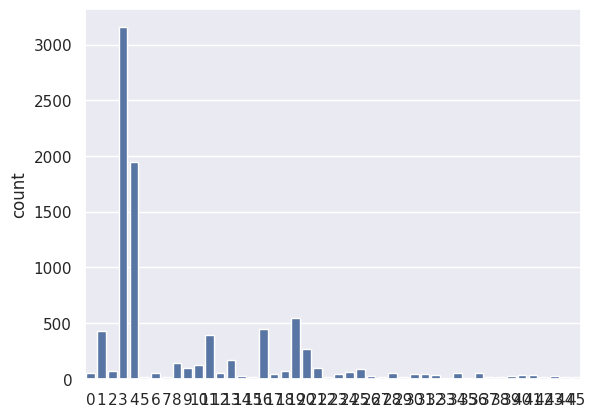

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=train_labels)

Wow... As you can see we have a ton of classes that seem to differ pretty wildly in distribution. There is a weird legend about these class labels: in `keras`, over the course of time, they have somehow lost track of which topics these integers actually represent... That doesn't change the actual data of course, but we don't know anymore  which topics are actually included, since there just... integers.

For this class, we will limit the dataset to the five classes that are the most common across the training and test dataset. Let us first establish which those five classes are, using a `Counter()`:

In [ ]:
from collections import Counter
cnt = Counter(list(train_labels))
num_classes = 5
cnt.most_common(num_classes)

[(3, 3159), (4, 1949), (19, 549), (16, 444), (1, 432)]

Ok, so we don't know what these classes actually represent in terms of newswire topics, but we do know that the classes 3, 4, 19, 16, and 1 were the most frequent. We'll now select those 5 classes into a separate list:

In [ ]:
selected_labels = sorted(set([i[0] for i in cnt.most_common(num_classes)]))
selected_labels

[1, 3, 4, 16, 19]

The next code block looks a bit more involved, but you'll see that we are basically just selecting the items in the train and test set that belong to one of the five classes that we just selected. Have a closer look at home: the only weird thing is perhaps the reindexing operation: here, we convert the original topic indices (cf. `[1, 3, 4, 16, 19]`) by reindexing them as: `[0, 1, 2, 3, 4]`.

In [ ]:
train_mask = [True if l in selected_labels else False for l in train_labels]
x_train = [item for item, mask_value in zip(decoded_train_data, train_mask) if mask_value]
y_train = train_labels[train_mask]
y_train = np.array([selected_labels.index(i) for i in y_train]) # reindex

test_mask = [True if l in selected_labels else False for l in test_labels]
x_test= [item for item, mask_value in zip(decoded_test_data, test_mask) if mask_value]
y_test = test_labels[test_mask]
y_test = np.array([selected_labels.index(i) for i in y_test]) # reindex


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

x_train = tfidf_vectorizer.fit_transform(x_train).todense()
x_test = tfidf_vectorizer.transform(x_test).todense()

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# A dev set is usually taken from a train set, if a test set is already provided
# The correct version should be:
# x_test, x_dev, y_test, y_dev = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_test)

x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)
print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(6533, 5000)
(812, 5000)
(812, 5000)
(6533,)
(812,)
(812,)


In [ ]:
max(y_test)

4

In [ ]:
def np2iter(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.float)
  # y = np.expand_dims(y, axis=1)
  y = torch.tensor(y, dtype=torch.long)
  print(y.shape)

  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=32, shuffle=shuffle)

train_iter = np2iter(x_train, y_train, shuffle=True)
dev_iter =  np2iter(x_dev, y_dev, shuffle=False)
test_iter =  np2iter(x_test, y_test, shuffle=False)

torch.Size([6533])
torch.Size([812])
torch.Size([812])


You can tell from the first dimensions of our matrices that we have downsampled our data quite a bit. We are now ready to define our network. Again, (disappointingly!) little changes (we don't have here an activation function because it is part of the cost function):

In [ ]:
class MultiClassModel(nn.Module):
  def __init__(self, in_features, out_features):
    super(MultiClassModel, self).__init__()
    self.layer = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    return self.layer(x)


The only thing which we should replace is the **softmax activation** (but it is a part of the objective function), which we use to convert the output activations for each class into **pseudo-probabilities** (that will sum to one). Below, we import the corresponding softmax function from `scipy`, so that we can understand it's effect:

In [ ]:
from scipy.special import softmax

print(softmax([0, 3, 2, 7, 12]))
print(softmax([0, 3, 2, 7, 12]).sum())


print(softmax([31, 8, 29, 0, 16]))
print(softmax([31, 8, 29, 0, 16]).sum())

[6.10202963e-06 1.22562541e-04 4.50882392e-05 6.69168802e-03
 9.93134559e-01]
1.0
[8.80796841e-01 9.03863116e-11 1.19202890e-01 3.03212296e-14
 2.69437797e-07]
0.9999999999999999


Again: you'll never have to implement this yourself -- but it's good to know what kind normalization operation it results in.

The loss is now set to the **crossentropy** that also incorporates the softmax function (almost, check the documentation). Let's train our model:

In [ ]:
from sklearn.metrics import accuracy_score

def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)


classification_model = MultiClassModel(in_features=x_train.shape[1], out_features=num_classes)
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=15)

epoch 1 train loss: 1.1954 val_cls: 1.0391 val_acc: 0.6675
epoch 2 train loss: 1.0121 val_cls: 0.9355 val_acc: 0.7352
epoch 3 train loss: 0.9305 val_cls: 0.8711 val_acc: 0.7167
epoch 4 train loss: 0.8741 val_cls: 0.8238 val_acc: 0.7192
epoch 5 train loss: 0.8299 val_cls: 0.7860 val_acc: 0.7167
epoch 6 train loss: 0.7932 val_cls: 0.7536 val_acc: 0.7254
epoch 7 train loss: 0.7614 val_cls: 0.7261 val_acc: 0.7438
epoch 8 train loss: 0.7334 val_cls: 0.7011 val_acc: 0.7475
epoch 9 train loss: 0.7079 val_cls: 0.6794 val_acc: 0.7796
epoch 10 train loss: 0.6853 val_cls: 0.6591 val_acc: 0.7722
epoch 11 train loss: 0.6644 val_cls: 0.6406 val_acc: 0.7919
epoch 12 train loss: 0.6452 val_cls: 0.6238 val_acc: 0.7993
epoch 13 train loss: 0.6276 val_cls: 0.6086 val_acc: 0.8116
epoch 14 train loss: 0.6114 val_cls: 0.5942 val_acc: 0.8227
epoch 15 train loss: 0.5962 val_cls: 0.5815 val_acc: 0.8325


We can again plot some learning curves for the training data:

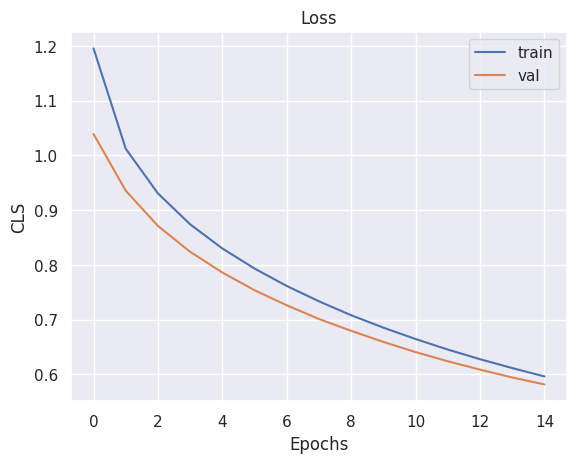

In [ ]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_cls"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('CLS');
plt.legend()

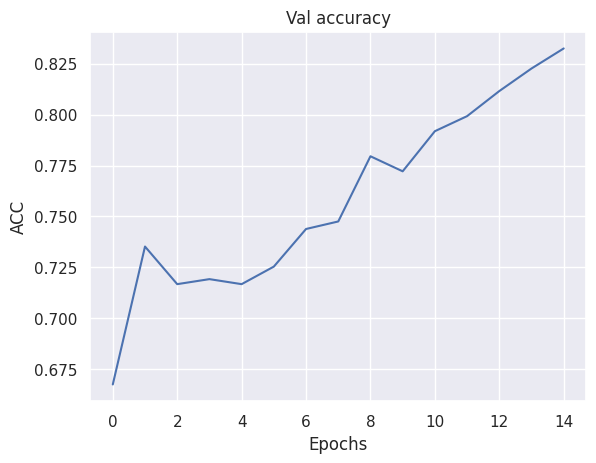

In [ ]:
plt.plot(history["val_acc"])
plt.title('Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('ACC');

We can obtain predictions for the test set too:

In [ ]:
pred = utils.test(classification_model, test_iter)

print(pred.shape) # no longer single output per instance...
print(pred[:10])

torch.Size([812, 5])
tensor([[-7.2067e-01,  2.6752e+00,  2.6405e-05, -8.9317e-01, -1.0070e+00],
        [-8.3508e-01,  3.5272e+00, -4.3184e-01, -1.0002e+00, -1.2019e+00],
        [-4.6193e-01,  1.1614e-01,  1.3596e+00, -4.5590e-01, -4.8626e-01],
        [-8.1070e-01,  8.1735e-02,  2.2474e+00, -7.1930e-01, -7.2677e-01],
        [-8.3891e-01,  3.9213e+00, -5.8395e-01, -1.0314e+00, -1.3676e+00],
        [-6.8176e-01,  5.0888e-02,  1.6643e+00, -4.6550e-01, -5.0634e-01],
        [-6.0300e-01,  2.2913e-01,  1.2717e+00, -2.4263e-01, -5.7476e-01],
        [-6.6831e-01,  5.8605e-02,  2.1763e+00, -6.7482e-01, -8.1713e-01],
        [-9.3443e-01,  3.7805e+00, -6.3937e-01, -1.0009e+00, -1.1348e+00],
        [-4.7659e-01, -3.6045e-01,  1.0617e+00, -2.2656e-01,  3.9718e-02]])


... you can see that we in fact get a matrix with five columns for all instances in the test set. These are logits (unnormalised or not-yet normalised predictions by softmax) for each of the 5 classes involved! So, if you apply sofrmax to these numbers, you will get probabilities.


For each test instance, this gives us five logits, namely one for each class. If everything went well, the highest value per row indicates the predicted class.

Again, like with the decision criterion that we had to apply for converting the output from the binary network into actual class labels, we also need a method to extract the actual classes which were predicted by the network. Conceptually, this is straightforward, since this is the class corresponding the column which had the highest probability for the item. To extract that information, we'll make use of `np.argmax(... , axis=1)`, which means: "Give us, for each row in this matrix, the index of the column which has the highest score". That goes as follows:

In [ ]:
conv_pred = np.argmax(pred, axis=1)
conv_pred[:5]

tensor([1, 1, 2, 2, 1])

That's it... We're done! We now have regular class predictions again that we can feed to `sklearn`'s metrics as before:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(y_pred=conv_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.91      0.40      0.56        52
           1       0.94      0.88      0.91       407
           2       0.67      0.95      0.79       237
           3       0.90      0.37      0.52        49
           4       0.96      0.66      0.78        67

    accuracy                           0.82       812
   macro avg       0.87      0.65      0.71       812
weighted avg       0.86      0.82      0.82       812



Let's try deeper model:

In [ ]:
class DeepModel(nn.Module):
  def __init__(self, in_features, out_features):
    super(DeepModel, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features, out_features=16),
                                nn.ReLU(),
                                nn.Linear(in_features=16, out_features=16),
                                nn.ReLU(),
                                nn.Linear(in_features=16, out_features=out_features))


  def forward(self, x):
    return self.layer(x)


In [ ]:
classification_model = DeepModel(in_features=x_train.shape[1], out_features=num_classes)
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=15)

epoch 1 train loss: 1.3044 val_cls: 1.1547 val_acc: 0.5000
epoch 2 train loss: 0.9533 val_cls: 0.8063 val_acc: 0.7352
epoch 3 train loss: 0.7854 val_cls: 0.7289 val_acc: 0.7500
epoch 4 train loss: 0.7085 val_cls: 0.6635 val_acc: 0.7549
epoch 5 train loss: 0.6496 val_cls: 0.7897 val_acc: 0.7352
epoch 6 train loss: 0.6253 val_cls: 0.5954 val_acc: 0.7882
epoch 7 train loss: 0.5802 val_cls: 0.5663 val_acc: 0.8153
epoch 8 train loss: 0.5201 val_cls: 0.5561 val_acc: 0.8214
epoch 9 train loss: 0.4372 val_cls: 0.4924 val_acc: 0.8448
epoch 10 train loss: 0.3740 val_cls: 0.4282 val_acc: 0.8682
epoch 11 train loss: 0.3147 val_cls: 0.3955 val_acc: 0.8978
epoch 12 train loss: 0.2780 val_cls: 0.3874 val_acc: 0.8990
epoch 13 train loss: 0.2466 val_cls: 0.3828 val_acc: 0.9027
epoch 14 train loss: 0.2224 val_cls: 0.4340 val_acc: 0.8916
epoch 15 train loss: 0.1978 val_cls: 0.3639 val_acc: 0.9064


In [ ]:
pred = utils.test(classification_model, test_iter)
conv_pred = np.argmax(pred, axis=1)

Results are much better!

In [ ]:
print(classification_report(y_pred=conv_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        52
           1       0.94      0.97      0.95       407
           2       0.92      0.88      0.90       237
           3       0.74      0.86      0.79        49
           4       0.92      0.87      0.89        67

    accuracy                           0.92       812
   macro avg       0.88      0.88      0.88       812
weighted avg       0.92      0.92      0.92       812



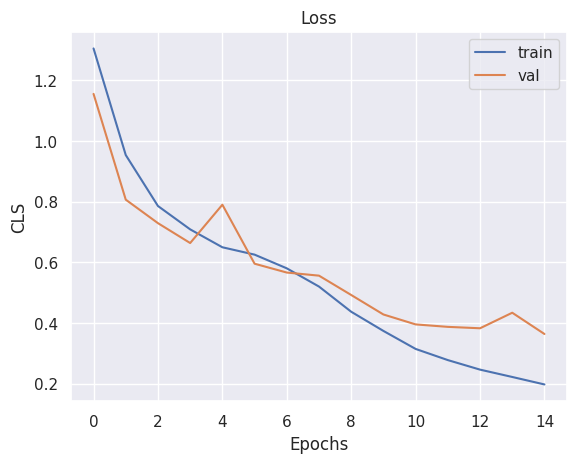

In [ ]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_cls"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('CLS');
plt.legend()

# Early Stopping

Early stopping is interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).

In [ ]:
class DeeperModel(nn.Module):
  def __init__(self, in_features, out_features):
    super(DeeperModel, self).__init__()
    self.layer = nn.Sequential(nn.Linear(in_features, out_features=100),
                                nn.ReLU(),
                                nn.Linear(in_features=100, out_features=100),
                                nn.ReLU(),
                                nn.Linear(in_features=100, out_features=out_features))


  def forward(self, x):
    return self.layer(x)




classification_model = DeeperModel(in_features=x_train.shape[1], out_features=num_classes)
classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=100)

epoch 1 train loss: 1.2782 val_cls: 1.1137 val_acc: 0.5345
epoch 2 train loss: 0.9290 val_cls: 0.8114 val_acc: 0.7217
epoch 3 train loss: 0.7876 val_cls: 0.7490 val_acc: 0.7438
epoch 4 train loss: 0.7126 val_cls: 0.7048 val_acc: 0.7451
epoch 5 train loss: 0.5935 val_cls: 0.5476 val_acc: 0.8177
epoch 6 train loss: 0.4876 val_cls: 0.4879 val_acc: 0.8190
epoch 7 train loss: 0.4407 val_cls: 0.4567 val_acc: 0.8436
epoch 8 train loss: 0.3937 val_cls: 0.4223 val_acc: 0.8916
epoch 9 train loss: 0.3436 val_cls: 0.4458 val_acc: 0.8732
epoch 10 train loss: 0.2943 val_cls: 0.6779 val_acc: 0.7660
epoch 11 train loss: 0.2528 val_cls: 0.3648 val_acc: 0.9064
epoch 12 train loss: 0.2230 val_cls: 0.3519 val_acc: 0.9138
epoch 13 train loss: 0.2046 val_cls: 0.3402 val_acc: 0.9236
epoch 14 train loss: 0.1839 val_cls: 0.4215 val_acc: 0.8818
epoch 15 train loss: 0.1663 val_cls: 0.3540 val_acc: 0.9076
epoch 16 train loss: 0.1516 val_cls: 0.3686 val_acc: 0.9076
epoch 17 train loss: 0.1429 val_cls: 0.4133 val_a

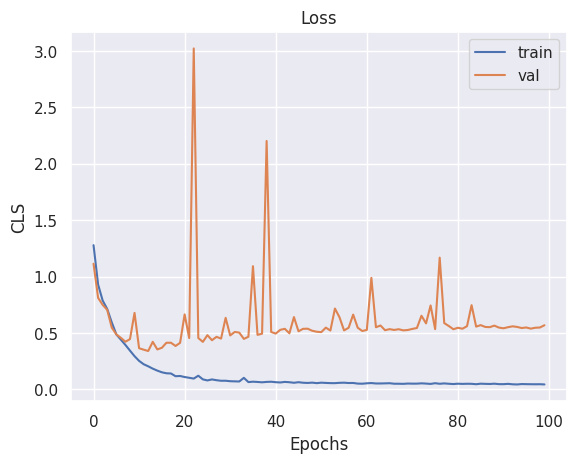

In [ ]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_cls"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('CLS');
plt.legend()

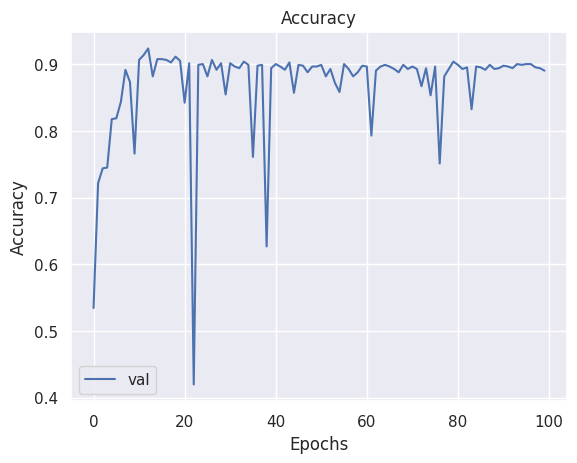

In [ ]:
plt.plot(history['val_acc'],  label='val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pred = utils.test(classification_model, test_iter)
conv_pred = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(y_pred=conv_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87        52
           1       0.95      0.95      0.95       407
           2       0.93      0.84      0.88       237
           3       0.82      0.92      0.87        49
           4       0.75      0.90      0.82        67

    accuracy                           0.91       812
   macro avg       0.86      0.90      0.88       812
weighted avg       0.91      0.91      0.91       812



Let's use early stopping:

In [ ]:
classification_model = DeeperModel(in_features=x_train.shape[1], out_features=num_classes)

classification_model = classification_model.cuda()

history = utils.train(model=classification_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.SGD(classification_model.parameters(), lr=0.1),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=100,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5, minimize=True))

epoch 1 train loss: 1.2786 val_cls: 1.0935 val_acc: 0.4988
tensor(1.0935) None
epoch 2 train loss: 0.9207 val_cls: 0.8131 val_acc: 0.7217
tensor(0.8131) tensor(1.0935)
epoch 3 train loss: 0.7808 val_cls: 0.7260 val_acc: 0.7475
tensor(0.7260) tensor(0.8131)
epoch 4 train loss: 0.6817 val_cls: 0.6366 val_acc: 0.7586
tensor(0.6366) tensor(0.7260)
epoch 5 train loss: 0.5470 val_cls: 0.6140 val_acc: 0.7672
tensor(0.6140) tensor(0.6366)
epoch 6 train loss: 0.4736 val_cls: 0.7193 val_acc: 0.7537
tensor(0.7193) tensor(0.6140)
epoch 7 train loss: 0.4360 val_cls: 0.4519 val_acc: 0.8350
tensor(0.4519) tensor(0.6140)
epoch 8 train loss: 0.3946 val_cls: 0.5946 val_acc: 0.8042
tensor(0.5946) tensor(0.4519)
epoch 9 train loss: 0.3512 val_cls: 0.4016 val_acc: 0.9052
tensor(0.4016) tensor(0.4519)
epoch 10 train loss: 0.3071 val_cls: 0.5183 val_acc: 0.8571
tensor(0.5183) tensor(0.4016)
epoch 11 train loss: 0.2569 val_cls: 0.3576 val_acc: 0.9101
tensor(0.3576) tensor(0.4016)
epoch 12 train loss: 0.2162 v

/content/utils.py:353: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [ ]:
pred = utils.test(classification_model, test_iter)
conv_pred = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(y_pred=conv_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.96      0.95      0.95       407
           2       0.91      0.91      0.91       237
           3       0.80      0.90      0.85        49
           4       0.92      0.85      0.88        67

    accuracy                           0.92       812
   macro avg       0.89      0.91      0.90       812
weighted avg       0.93      0.92      0.93       812



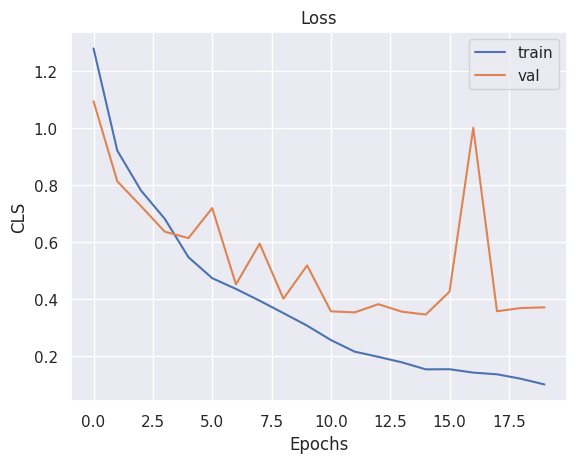

In [ ]:
plt.plot(history["train_loss"], label='train')
plt.plot(history["val_cls"], label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('CLS');
plt.legend()

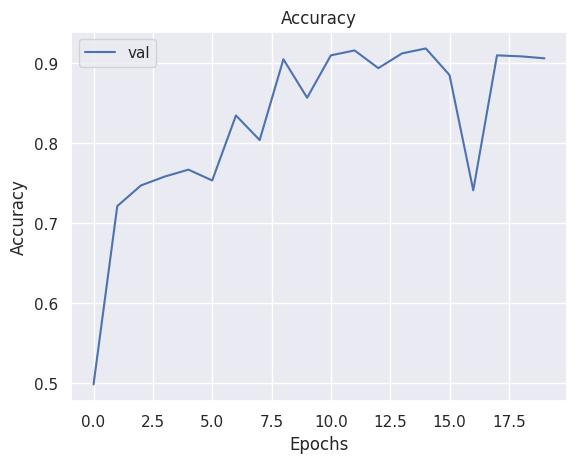

In [ ]:
plt.plot(history['val_acc'],  label='val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()